In [2]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [3]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [4]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path

import torch
from tqdm.autonotebook import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import pytorch3d

from utils import utils
import deformation.losses as def_losses
from utils.datasets import GenerationDataset, ShapenetRendersDataset, ShapenetPointsDataset
from utils.datasets import gen_data_collate
from utils import coords


In [5]:
gpu_num = 0
device = torch.device("cuda:"+str(gpu_num))
cfg_path = "configs/default.yaml"
cfg = utils.load_config(cfg_path, "configs/default.yaml")

In [6]:
def plot_pointcloud(pointcloud):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = pointcloud[:,0]
    y = pointcloud[:,1]
    z = pointcloud[:,2]
    ax.scatter(x,y,z, marker = '.')

In [6]:
# converts R,T (tensors) to batched extrinsic matrix (tensor, in device)
def R_T_to_Extrinsic(R,T, device):
    R = R[0].cpu().numpy()
    T = T[0].cpu().numpy().reshape(-1,1)
    C = np.zeros([3])
    D = np.array([1])
    P_target = torch.tensor([np.block([[R,T],[C,D]])], dtype=torch.float).to(device)
    return P_target
# C1 -> C2
def get_transform(C1, C2, device):
    A = C2[0][:3,:3].cpu().numpy().T @ C1[0][:3,:3].cpu().numpy() 
    B = (C1[0][:3, 3] - C2[0][:3, 3]).reshape((-1,1)).cpu().numpy()
    C = np.zeros([3])
    D = np.array([1])
    transform = torch.tensor([np.block([[A,B],[C,D]])], dtype=torch.float).to(device)
    return transform

R_1, T_1 = look_at_view_transform(eye=torch.tensor([[3.3,4.0,1.0]]))
P_1 = R_T_to_Extrinsic(R_1, T_1, device)
print(P_1)
R_target, T_target = look_at_view_transform(eye=torch.tensor([[0.0,0.0,2.0]]))
P_target = R_T_to_Extrinsic(R_target, T_target, device)
print(P_target)
transform = get_transform(P_1, P_target, device)
print(transform)
print(P_target @ transform)

In [11]:
generation_dataset = GenerationDataset(cfg)
generation_loader = torch.utils.data.DataLoader(generation_dataset, batch_size=4, shuffle=False, collate_fn=gen_data_collate)

Loading cached generation dataset at caches/generation_dataset_cache_480.pt...


torch.Size([4, 1502, 3])
torch.Size([4, 3])


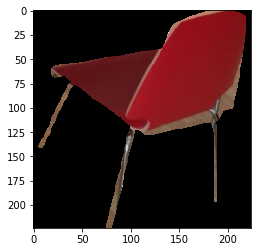

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


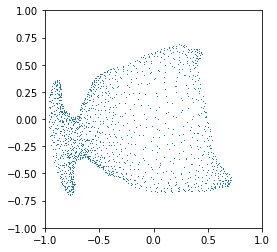

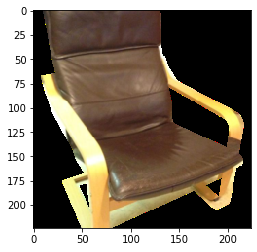

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


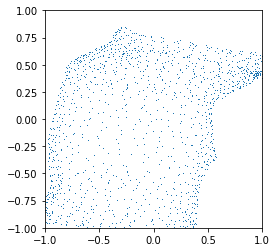

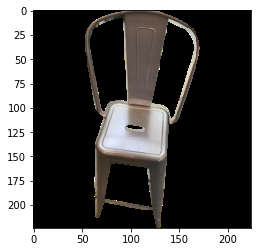

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


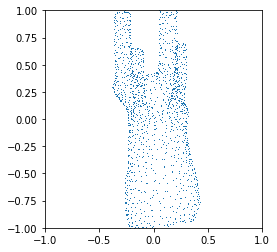

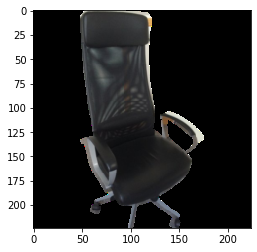

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


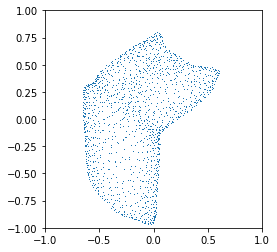

In [43]:
for batch in generation_loader:
    mesh_batch = batch["mesh"].to(device)
    verts_padded = mesh_batch.verts_padded()
    poses = batch["pose"].to(device)
    print(verts_padded.shape)
    print(poses.shape)
    aligned_verts_padded = coords.align_and_normalize_verts(verts_padded, poses, device)
    
    for i,aligned in enumerate(aligned_verts_padded):
        # show image
        image = batch["image"][i]
        plt.imshow(image.permute(1,2,0).numpy())
        plt.show()
        # show aligned points
        x = aligned.cpu().numpy()[:,0]
        y = aligned.cpu().numpy()[:,1]
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.axes().set_aspect('equal')
        plt.plot(x,y, ',')
        plt.show()
    
    break

[autoreload of utils.coords failed: Traceback (most recent call last):
  File "/opt/conda/envs/standard/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/envs/standard/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/opt/conda/envs/standard/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/opt/conda/envs/standard/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/svcl-oow

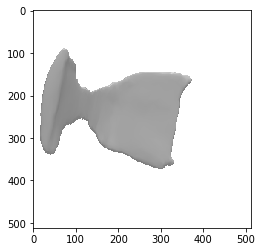

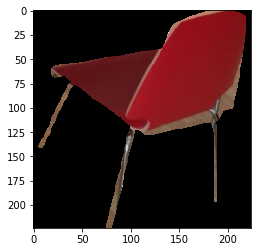

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


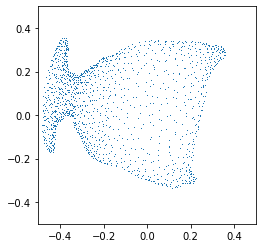

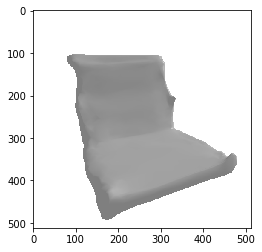

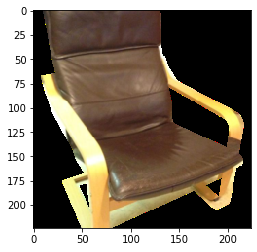

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


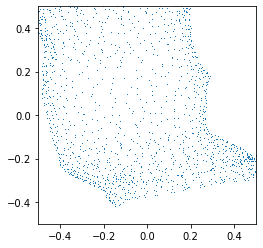

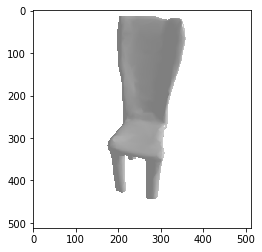

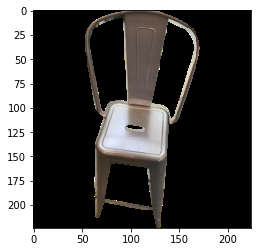

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


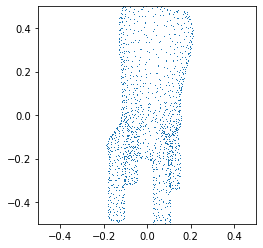

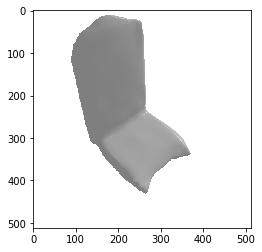

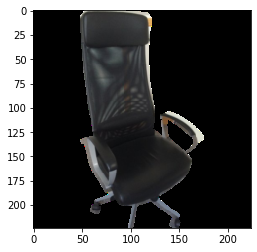

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


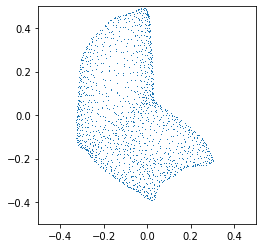

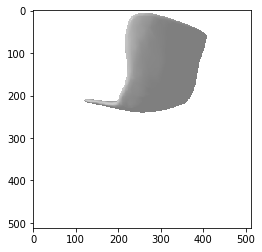

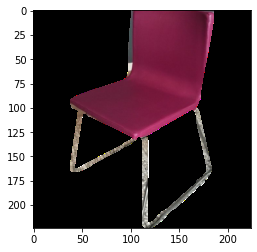

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


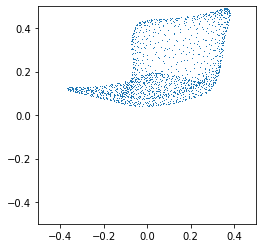

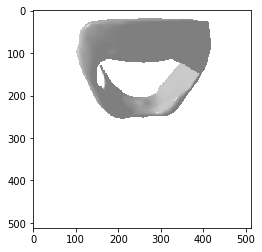

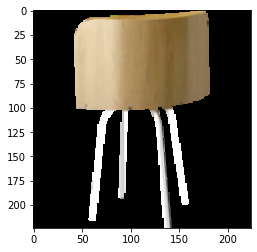

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


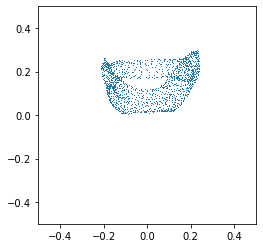

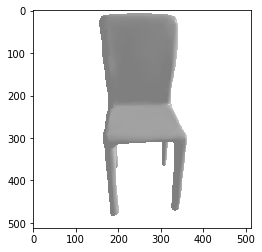

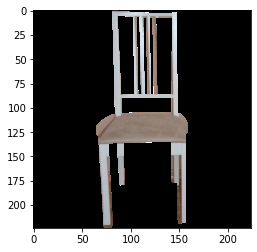

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


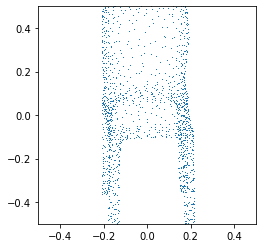

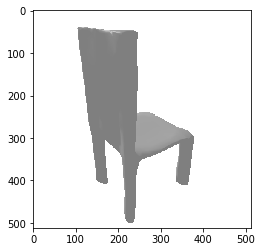

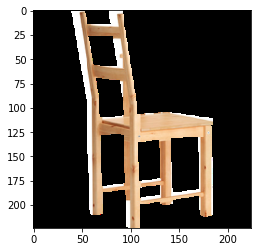

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


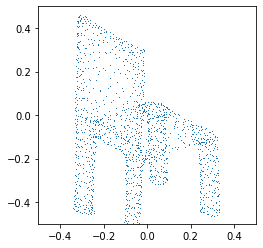

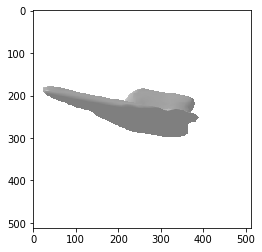

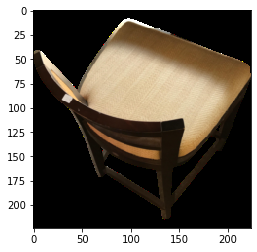

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


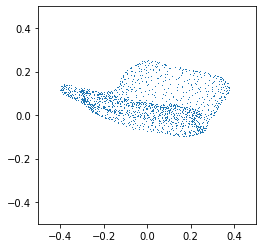

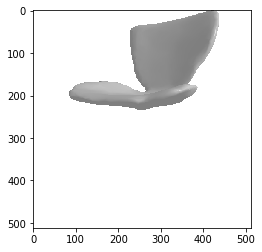

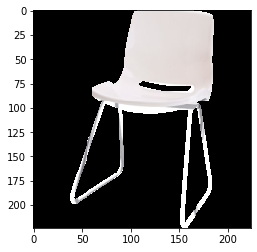

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


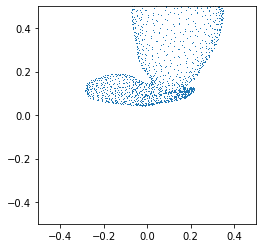

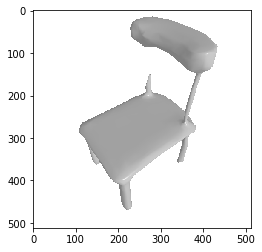

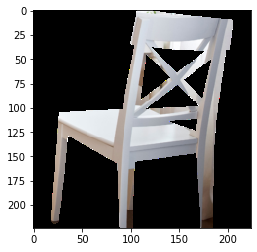

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


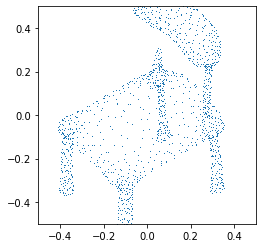

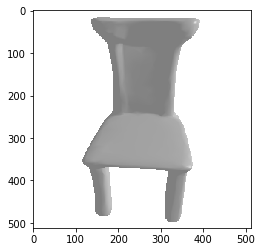

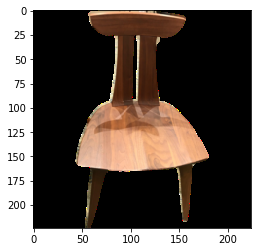

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


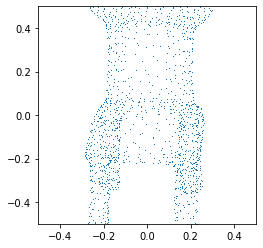

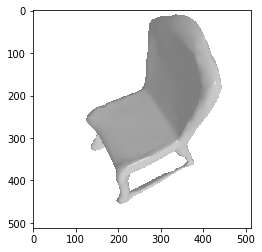

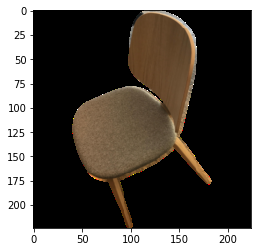

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


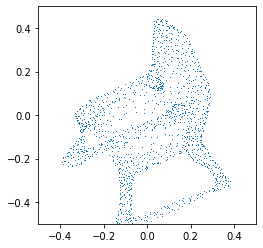

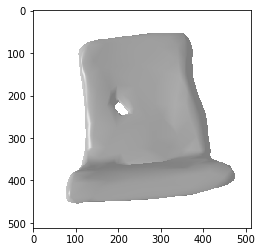

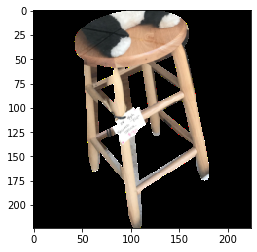

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


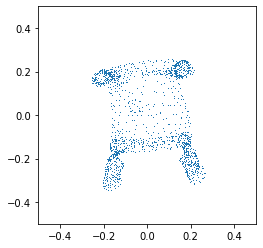

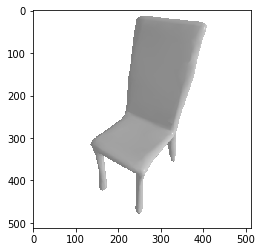

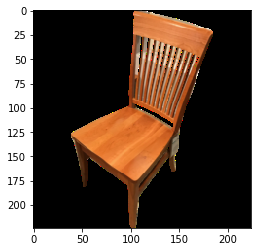

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


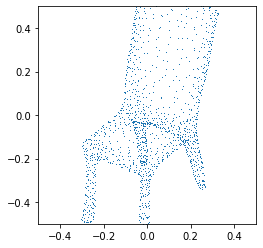

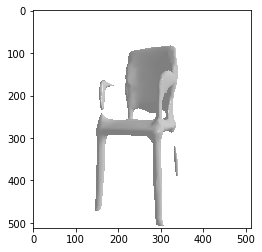

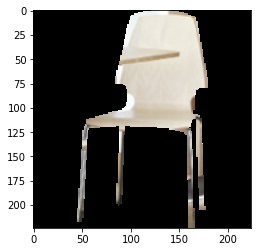

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


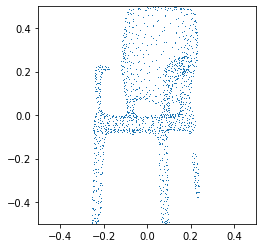

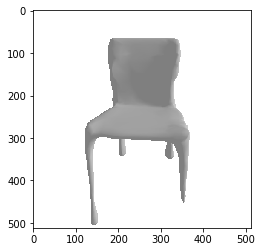

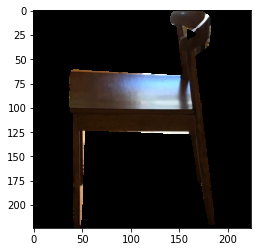

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


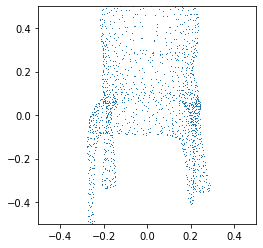

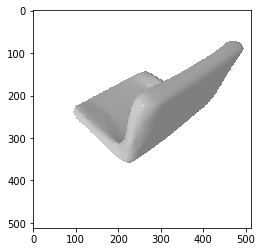

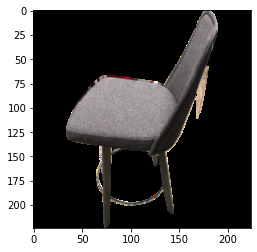

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


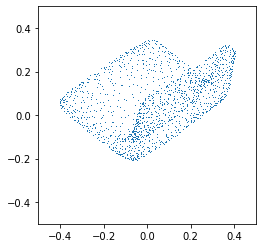

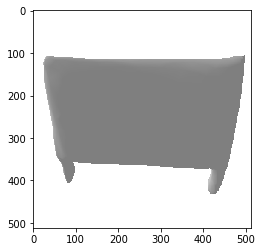

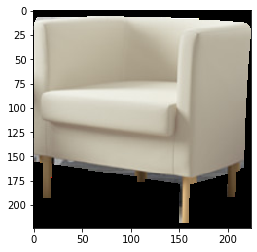

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


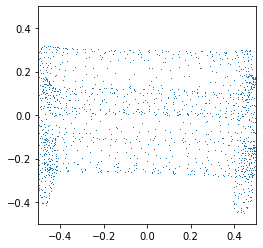

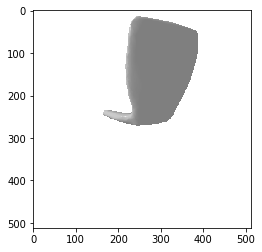

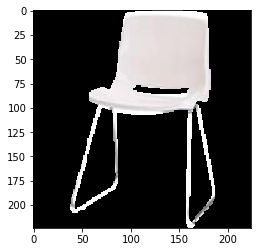

/opt/conda/envs/standard/lib/python3.6/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


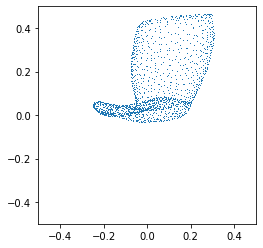

In [16]:
for i in range(20):
    input_batch = generation_dataset[i]

    image = input_batch["image"]
    mesh_batch = input_batch["mesh"].to(device)
    verts_padded = mesh_batch.verts_padded()
    pose = input_batch["pose"].to(device)
    distance = pose[0]
    elevation = pose[1]
    azimuth = pose[2]

    # rendering image
    R, T = look_at_view_transform(distance, elevation, azimuth)
    mesh_original_render = utils.render_mesh(mesh_batch, R, T, device)

    plt.imshow(mesh_original_render[0, ..., :3].cpu().numpy())
    plt.show()
    plt.imshow(image.permute(1,2,0).numpy())
    plt.show()

    # computing transformation
    A = R[0].cpu().numpy()
    B = T[0].cpu().numpy().reshape(-1,1)
    C = np.zeros([3])
    D = np.array([1])
    P1 = torch.tensor([np.block([[A,B],[C,D]])], dtype=torch.float).to(device)
    P1 = torch.inverse(P1)
    align_1 = coords.rotate_verts(P1, verts_padded)
    align_1 = align_1[0]
    
    # reflecting
    sym_plane = [1,0,0]
    N = np.array([sym_plane])
    reflect_matrix = torch.tensor(np.eye(3) - 2*N.T@N, dtype=torch.float).to(device)
    align_1 = align_1 @ reflect_matrix

    x = align_1.cpu().numpy()[:,0]
    y = align_1.cpu().numpy()[:,1]
    plt.xlim(-0.5,0.5)
    plt.ylim(-0.5,0.5)
    plt.axes().set_aspect('equal')
    plt.plot(x,y, ',')
    plt.show()